In the proposal, I used the loss 
$$
\mathcal{L} =  - \log f(x_u; \theta) + \log f(x_d; \theta)
$$
Where $f$ is the computed probability, $x_u$ is a sample drawn from the unknown distribution $P_u$ we are trying to model, and $x_d$ is drawn from $f_{\theta}$.

The expected value of this Loss is:
$$
\hat{\mathcal{L}} = \int f_{\theta}(x)\log (f_{\theta}(x)) dx - \int P_u(x)\log (f_{\theta}(x)) dx = 
\int \log (f_{\theta}(x)) [ f_{\theta}(x) - P_u(x)] dx
$$


However, $f_{\theta} = P_u$ is definitely not a global optimum, as is easy to demonstrate with a simple, discrete distribution over two events.




Without further ado, let's plot this loss for all possible distributions $f$, where $P_u$ is known:

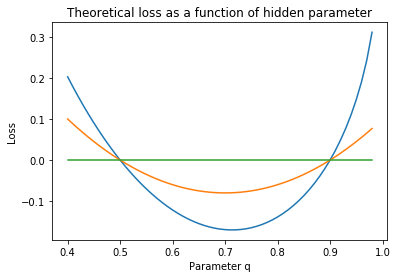

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Modeled, unkown distribution
p_a = 0.9
p_b = 1 - p_a

#f is parametrized by one value, f_a; f_b = 1 - f_a

def Loss(f_a):
    return np.log(f_a)*(f_a - p_a) + np.log(1 - f_a) * (1 - f_a - p_b)

def Loss2(f_a):
    """Just to show the same thing happens if we use probability instead of log-likelihood"""
    return (f_a)*(f_a - p_a) + (1 - f_a) * (1 - f_a - p_b)

x = np.arange(0.4, 0.99, 0.01)
y = np.array([0 for i in x])
l = Loss(x)
l2 = Loss2(x)

plt.plot(x, l)
plt.plot(x, l2)
plt.plot(x, y)
plt.xlabel('Parameter q')
plt.ylabel('Loss')
plt.title('Theoretical loss as a function of hidden parameter')
plt.show()

In the presence of true gradient descent, of course, this would imply that a procedure which performs gradient descent ought not to converge to the true value.

However, we can build a small model, on two events, and test whether the hidden probability converges to the true.

In [33]:
import torch

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from copy import deepcopy
import math
import numpy as np

import numpy as np
import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"



class event(nn.Module):
    def __init__(self):
        """Even n preferred"""
        super(event, self).__init__()
        self.q = Parameter(torch.tensor(0.1))
    
    def forward(self, x): 
        return torch.log(self.q)*x + torch.log(1 - self.q)*(1 - x)
    
    def sample(self, n): 
        x = torch.zeros(n).cuda()
        x.uniform_(0, 1)
        return (torch.sign(x + self.q -1) + 1)/2.


model = event().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [34]:
qs     = torch.zeros(10000).cuda()
losses = torch.zeros(10000).cuda()
epochs  = torch.zeros(10000).cuda()

for epoch in range(10000):
    xu = torch.zeros(1000).cuda()
    xu.uniform_(0, 1)
    
    #Sampling with a true probability of 0.9
    xu = (torch.sign(xu - 1 + 0.9) + 1)/2

    xd = model.sample(1000)

    model.train()
    model.zero_grad()

    L = torch.sum(model(xd)) - torch.sum(model(xu))

    L.backward()
    optimizer.step()
    
    epochs[epoch] += epoch
    qs[epoch]     += model.q
    losses[epoch] += L
#    print(epoch)
#    print(L)
#    print(model.q)
#    print('\n\n\n')

print(model.q)

Parameter containing:
tensor(0.8968, device='cuda:0')


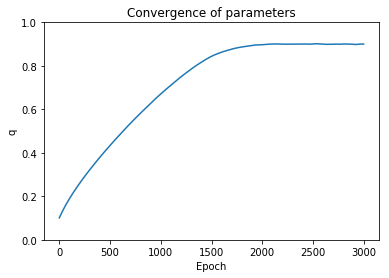

In [35]:
plt.plot(epochs.cpu().detach().numpy()[:3000], qs.cpu().detach().numpy()[:3000])
plt.xlabel('Epoch')
plt.ylabel('q')
plt.ylim(0, 1)
plt.title("Convergence of parameters")
plt.show()

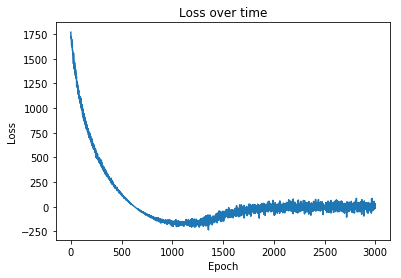

In [36]:
plt.plot(epochs.cpu().detach().numpy()[:3000], losses.cpu().detach().numpy()[:3000])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over time")
plt.show()

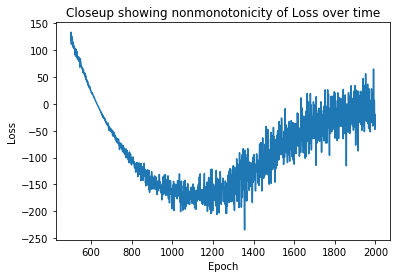

In [37]:
plt.plot(epochs.cpu().detach().numpy()[500:2000], losses.cpu().detach().numpy()[500:2000])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Closeup showing nonmonotonicity of Loss over time")
plt.show()

So, what are we to make of this?

In conclusion, I think that the way the gradient is computed makes all the difference. The gradient is not computed with respect to the positions of $x_d$; that is, the algorithm does not try to place them in a convenient spot.

Still, I am now thoroughly confused on the subject of whether or not this self-adversary technique is a good idea.